In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
%matplotlib inline
sns.set(color_codes=True)

# Introduction

<p>The rise of online rating systems has had a major impact on the film industry, as on many others.  Critic and fan ratings are aggregated on popular websites like Metacritic and Rotten Tomatoes, where consumers can view both numbers to inform their decision-making.  In the early stages of a film's release, these ratings may affect consumer choices to a significant degree; once the box office run is complete, they serve as good indicators of a film's popular and critical reception, and, to some extent, as proxies for its artistic quality. </p>

<p>While the critical and popular ratings generally tend to correlate, there are well-known discrepancies between them.  The tastes of popular audiences and of critics differ, and as in most artistic fields, the nature and merit of those differences are debated.</p>

<p>This report examines ratings data on 225 films - fifteen films from every year from 2002 through 2016.  The data, pulled from Kaggle.com, was originally scraped from the International Movie Database (IMDb), Metacritic, and Rotten Tomatoes (RT).  It includes aggregated critic and fan ratings, as well as genre tags and basic data such as budget, year, and box office revenue.  Using this data, I will address questions like: </p>
<ul>
    <li>How much do fans and critics disagree, and on what sorts of movies?</li>
    <li>Do critical reviews, popular reviews, or some other factor better predict box office revenue?</li>
    <li>Are these patterns steady across the past fifteen years?</li>
    <li>Are there outlier films that defy these trends?</li>
</ul>

# Loading the data
<p>First we have to pull the ratings data from the primary dataset, moviesData.csv, and combine it with more extensive basic data from a larger but rating-less IMDb dataset (movies_basic_metadata.csv).

In [2]:
# upload and merge datasets
movies_df = pd.read_csv("moviesData.csv")
metadata_df = pd.read_csv("movies_basic_metadata.csv")
metadata_df = metadata_df[metadata_df["budget"]!="0"]
movies_df = movies_df.merge(metadata_df.drop_duplicates("title"), how="inner", left_on="Titles", right_on="title")

# tweak titles and scaling for ease of use
movies_df.rename(columns = {"Titles":"Title"}, inplace=True)
# rescale IMDb fan rating to match other aggregated ratings, which are out of 100
movies_df["IMDb"] *= 10
# convert budget to int (it's stored as a string for some reason)
movies_df.budget = movies_df.budget.astype(int)

# convert budget and BoxOffice to 2016 USD using data from usinflationalcalculator.com
inflation_dict = {2002:1.33, 2003:1.30 , 2004:1.26 , 2005:1.22 , 2006:1.19 , 2007:1.15 , 2008:1.11 , 2009:1.11 ,
              2010:1.10 , 2011:1.06 , 2012:1.04 , 2013:1.03 , 2014:1.01 , 2015:1.01, 2016:1.0 }
movies_df["budget"] = [inflation_dict[movies_df["Year"][i]] * movies_df["budget"][i] for i in range(len(movies_df))]
movies_df["BoxOffice"] = [inflation_dict[movies_df["Year"][i]] * movies_df["BoxOffice"][i] for i in range(len(movies_df))]
# convert budget and BoxOffice to millions
movies_df["budget"] /= 10**6
movies_df["BoxOffice"] /= 10**6
# ad-hoc correction due to title confusion
movies_df.loc[movies_df["title"]=="Cinderella","budget"] = 95

# create composite fan and critic ratings
movies_df["allFans"] = (movies_df["IMDb"] + movies_df["RTFan"])/2
movies_df["allCritics"] = (movies_df["RTCritic"] + movies_df["Metacritic"])/2
movies_df["aggregate_rating"] = (movies_df["allFans"] + movies_df["allCritics"]) / 2

# Movies at a glance
<p>The movies in this 15-year dataset are spread unevenly across genres, with Drama leading the way at 105, and Horror coming in last at just 18.  The genre tags are non-exclusive (a movie can be both Romance and Drama), so the genre counts add up to more than the total number of films in the dataset.</p>

In [3]:
genre_ratings = []
# there's only one documentary, and it's a mislabel (no, "Ice Age: The Meltdown" is not a documentary)
del movies_df["Documentary"]
# remove international, since there's also only one
del movies_df["International"]

genre_titles = list(movies_df)[10:17]
# compile counts, along with fan and critic rating means, associated with each genre
for genre_title in genre_titles:
    genre_ratings.extend( [
        genre_title,
        len(movies_df[movies_df[genre_title]==1]),
        movies_df[movies_df[genre_title]==1]["allFans"].mean(),
        movies_df[movies_df[genre_title]==1]["allCritics"].mean()
        ])
# reshape this list into a dataframe
genre_df = pd.DataFrame(np.array(genre_ratings).reshape(7,4), columns = ["genre","count", "allFans", "allCritics"])

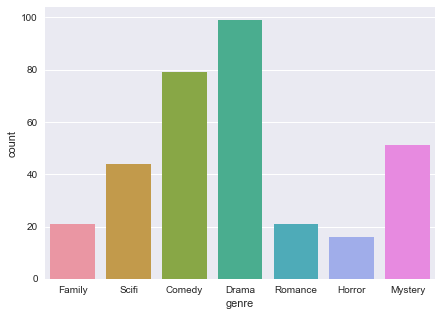

In [4]:
# graph the genre distribution
plt.figure(figsize=(7,5))
# it's unclear why "count" column needs to be retyped, but sns throws an error without it
genre_df["count"] = genre_df["count"].astype(int)
sns.barplot(x="genre", y="count", data=genre_df)
plt.show()

<p>The median budget of the films is \$27 million USD, while the median box office revenue is \$42 million.  The distributions of both budget and box office revenue cluster toward the left, with a small number of high-budget, high-revenue films trailing out to the right, roughly following a reciprocal function curve.  Neither budgets nor box office revenues showed any significant change across the 15 years included in the data.</p>

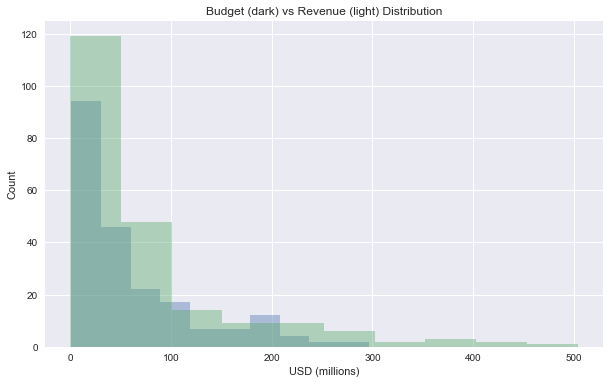

In [5]:
plt.figure(figsize=(10,6))
plt.hist(movies_df["budget"], alpha=0.4)
plt.hist(movies_df["BoxOffice"], alpha=0.4)
plt.xlabel('USD (millions)')
plt.ylabel('Count')
plt.title('Budget (dark) vs Revenue (light) Distribution')
plt.show()

# Ratings at a glance

<p>As we can see below, there are some significant differences in the distributions of the different ratings.  To begin with, the means of both fan ratings (Rotten Tomatoes(RT) fans and IMDb fans) are significantly higher than the mean of either critic rating mean.  The mean of the combined fan ratings (Rotten Tomatoes and IMDb) is 61.6, nearly nine percentage points higher than the mean of the combined critic ratings (52.1).</p>

<p>There are several possible explanations (not necessarily exclusive) for this difference in mean ratings from fans vs. critics.  The first is selection bias: fans mostly watch only those movies they expect to enjoy, whereas reviewers, as paid professionals, will watch movies for the purpose of reviewing that they would not watch for pleasure.  Second, fans may have a genuinely more enjoyable experience watching an average movie, since they are typically watching purely for recreation and not for work.  And third, critics are likely to make a greater conscious effort than fans to calibrate their ratings to the mean.</p>

<p>Aside from the difference of mean, it is also noteworthy that IMDb fan scores have the narrowest distribution (highly concentrated around a mean of 64), whereas the distribution of Rotten Tomatoes aggregated critical scores is nearly uniform.</p>

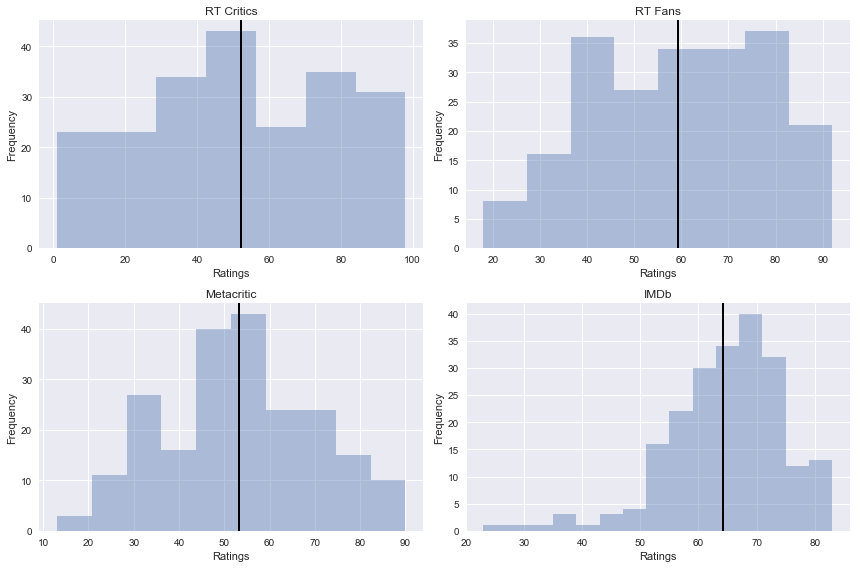

In [6]:
plt.figure(figsize=(12,8))
plt.subplot(2,2,1)
sns.distplot(movies_df['RTCritic'], label="RT Critic", kde=False)
plt.xlabel('Ratings')
plt.ylabel('Frequency')
plt.title('RT Critics')
plt.axvline(movies_df["RTCritic"].mean(), color='black', linewidth=2)

plt.subplot(2,2,2)
sns.distplot(movies_df['RTFan'], label="RT Fan", kde=False)
plt.xlabel('Ratings')
plt.ylabel('Frequency')
plt.title('RT Fans')
plt.axvline(movies_df["RTFan"].mean(), color='black', linewidth=2)

plt.subplot(2,2,3)
sns.distplot(movies_df['Metacritic'], label="Metacritic", kde=False)
plt.xlabel('Ratings')
plt.ylabel('Frequency')
plt.title('Metacritic')
plt.axvline(movies_df["Metacritic"].mean(), color='black', linewidth=2)

plt.subplot(2,2,4)
sns.distplot(movies_df['IMDb'], label="IMDb fans", kde=False)
plt.xlabel('Ratings')
plt.ylabel('Frequency')
plt.title('IMDb')
plt.axvline(movies_df["IMDb"].mean(), color='black', linewidth=2)
plt.tight_layout()
plt.show()

# Differences between fan and critic ratings

<p>While fan and critic ratings are by no means in lockstep, they do have a moderate-to-strong correlation (r=0.77).</p>

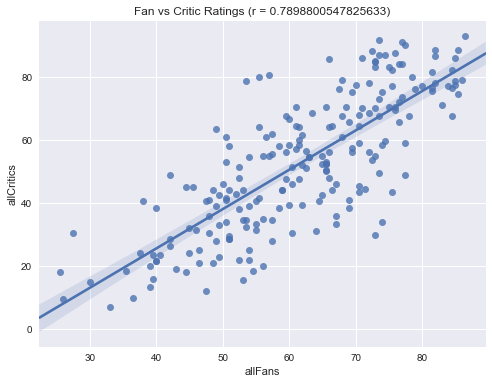

In [7]:
plt.figure(figsize=(8,6))
x = movies_df["allFans"]
y = movies_df["allCritics"]
sns.regplot(x,y)
r = np.corrcoef(x,y)[0,1]
plt.title("Fan vs Critic Ratings (r = {})".format(r));

It is worth noting that the correlations between the two fan groups (Rotten Tomatoes and IMDb) is not perfect either (r = 0.82).  The correlation between Rotten Tomato and Metacritic ratings is significantly closer (r = 0.93).  The latter correlation is unsurprising: although the two sites use different weightings in their aggregation algorithms, the actual critics used by Metacritic are almost entirely a subset of the broader selection included by Rotten Tomatoes.

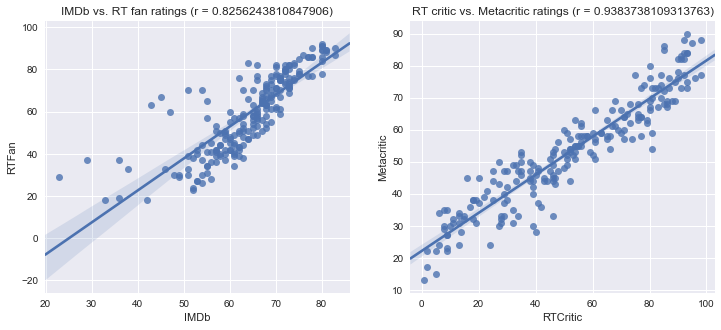

In [8]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
x = movies_df["IMDb"]
y = movies_df["RTFan"]
sns.regplot(x,y)
r = np.corrcoef(x,y)[0,1]
plt.title("IMDb vs. RT fan ratings (r = {})".format(r))

plt.subplot(1,2,2)
x = movies_df["RTCritic"]
y = movies_df["Metacritic"]
sns.regplot(x,y)
r = np.corrcoef(x,y)[0,1]
plt.title("RT critic vs. Metacritic ratings (r = {})".format(r));

<p>Both overall ratings and differences between fan and critic ratings show pronounced differences by genre.  Horror movies received the lowest ratings from both fans and critics.  Romance movies displayed the highest discrepancy between fan ratings and critic ratings, at just under five percentage points.</p>

In [9]:
genre_df

,genre,count,allFans,allCritics
0,Family,21,63.142857142857146,58.523809523809526
1,Scifi,44,60.93181818181818,49.55681818181818
2,Comedy,79,58.664556962025316,49.77215189873418
3,Drama,99,65.03535353535354,56.803030303030305
4,Romance,21,61.54761904761905,47.0
5,Horror,16,50.03125,37.9375
6,Mystery,51,57.3921568627451,48.59803921568628


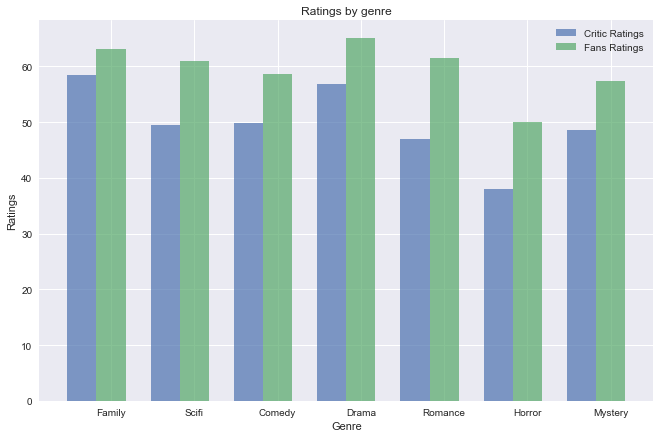

In [13]:
plt.figure(figsize=(11,7))

# this shouldn't be necessary, but otherwise the y axis gets totally screwed up
genre_df.to_csv("genres.csv")
genre_df = pd.read_csv("genres.csv")

n_groups = 7
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.7

rects1 = plt.bar(index, genre_df["allCritics"], bar_width,
                 alpha=opacity,
                 color='b',
                 label="Critic Ratings")
 
rects2 = plt.bar(index + bar_width, genre_df["allFans"], bar_width,
                 alpha=opacity,
                 color='g',
                 label="Fans Ratings")
plt.xlabel('Genre')
plt.ylabel('Ratings')
plt.title('Ratings by genre')
plt.xticks(index + bar_width, genre_df["genre"])

# from importlib import reload
# reload(plt)
# this inexplicably doesn't work
plt.set_ylim=(30,70)

plt.legend();

<p>However, mean-normalizing these averages paints a different picture. If we look at which genres fans liked better than most versus which genres critics liked better than most, we see that while critics and fans both favored Family movies, critics favored them by a much higher margin - even larger than the difference between the ratings for Romance movies, which fans favored but critics slightly disfavored.  Fan and critic mean-normalized ratings are fairly similar for Scifi, Comedy, Drama, and Mystery.</p> 

In [11]:
genre_df["normedAllFans"] = genre_df["allFans"] - genre_df["allFans"].mean()
genre_df["normedAllCritics"] = genre_df["allCritics"] - genre_df["allCritics"].mean()
genre_df

TypeError: Could not convert 63.14285714285714660.9318181818181858.66455696202531665.0353535353535461.5476190476190550.0312557.3921568627451 to numeric

<p>Finally, we might consider whether the quality of a film affets difference of opinion between fans and critics.  The answer?  There's basically no correlation (r = 0.004).  So fans and critics seem to disagree basically no more and no less about good movies than they do about bad movies.</p>

# Ratings as predictors of box office revenues
<p> Both fan and critic ratings do correlate positively with box office returns, but both correlations are very weak.  Interestingly, this implies that how much critics and fans like a movie - and, by proxy, how good a movie actually is - is a relatively small factor in determining how much money the movie brings in.</p>

In [ ]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
x = movies_df["allFans"]
y = movies_df["BoxOffice"]
sns.regplot(x,y)
r = np.corrcoef(x,y)[0,1]
plt.title("Fan ratings vs box office revenue (r = {})".format(r))

plt.subplot(1,2,2)
x = movies_df["allCritics"]
y = movies_df["BoxOffice"]
sns.regplot(x,y)
r = np.corrcoef(x,y)[0,1]
plt.title("Critic ratings vs box office revenue (r = {})".format(r))
plt.show()


<p>Of all the features in the dataset, the feature that correlates most closely with box office revenue is actually budget.  In other words, it seems that regardless of the actual quality of the movie, pouring money into the project generates even greater revenue.  A higher budget gives a movie a number of quality-independent advantages for selling tickets:</p>
<ul>
    <li>A major portion of the budget is spent on promotions such as trailers, posters, and social media hype </li>
    <li>Hiring big-name actors and directors will draw fan subgroups</li>
    <li>Expensive high-quality visual effects make for more compelling trailers</li>
</ul>

<p>The high-profit films that are well above this budget vs. box office ratio are mostly sequels in successful series such as Iron Man, Spiderman, and (claiming the highest grossing film at over \$500 million) Pirates of the Caribbean.  In these cases a great deal of popularity has already been generated through promotion for previous films, through the previous films themselves, and through associated merchandizing, before a dollar of the new film's budget has been spent. They begin their product cycle at an enormous advantage.  So while Hollywood's propensity for sequels and remakes may come at some cost to the artistic value of film, it certainly makes good business sense.</p>

In [ ]:
plt.figure(figsize=(7,6))
x = movies_df["budget"]
y = movies_df["BoxOffice"]
sns.regplot(x,y)
r = np.corrcoef(x,y)[0,1]
plt.title("Budget vs Box Office (r = {})".format(r))
plt.show()

One other important metric of profitability is the profit percentage - box office gross expressed as a percentage of the initial budget.  In this category there are two enormous outliers: the 2008 Christian drama <i>Fireproof</i> at 67 and the 2006 global warming documentary <i>An Inconvenient Truth</i> at 24 (the mean was 2.0). In both cases, it would seem that the interfering factor in normal consumer tendencies was ideology, which can conceivably trump normal film-quality considerations in the minds of consumers.</p>

<p> Even after eliminating these two outliers, there is little correlation to either fan or critic ratings.  It would seem that consumer choice in theater tickets is a complex social phenomenon that doesn't neatly correlate to consumers' actual opinions of film quality.  The only clear predictor of ticket sales in this dataset is budget, which partly reflects the extent of a multi-million-dollar promotional campaign specificallly designed to increase the number of tickets sold.</p>

In [ ]:
movies_df["profit_pct"] = movies_df["BoxOffice"] / movies_df["budget"]
# create copy without the two major profit_pct outliers
movies_df2 = movies_df.copy()
movies_df2 = movies_df2[movies_df2["title"]!="Fireproof"]
movies_df2 = movies_df2[movies_df2["title"]!="An Inconvenient Truth"]

plt.figure(figsize=(7,6))
x = movies_df2["aggregate_rating"]
y = movies_df2["profit_pct"]
sns.regplot(x,y)
r = np.corrcoef(x,y)[0,1]
plt.title("Profit Percentage vs Aggregate Rating (r = {})".format(r))
plt.show()

# Conclusions

<p>We can now give some definite answers to the questions raised at the beginning of this report.</p>
<ul>
    <li><strong>How much do fans and critics disagree, and on what sorts of movies?</strong> Fans generally rate movies about 9 percentage points higher than critics.  This trend holds across films of different qualities and years.  If we mean normalize scores to find out <i>how much better or worse than average</i> fans and critics scored a movie,  we find significant differences across genres: fans like Romances more than critics do, and critics rate Family movies much higher than fans do.</li>
    <li><strong>Do critical reviews, popular reviews, or some other factor better predict box office revenue?</strong>  Neither fan nor critic ratings have a very large effect on box office revenues. By far the best predictor in this dataset was budget.  This suggests that, from a purely profit-maximizing perspective, sectors of a film's budget not directly related to film quality (such as promotional expenses) may actually have greater impact on ticket sales.</li>
    <li><strong>Are these patterns steady across the past fifteen years?</strong>  Yes.</li>
    <li><strong>Are there outlier films that defy these trends?</strong>  Yes.  Sequels in popular film series outperform box office projections, probably due to the popularity associated with their predecessors.  Ideological films that resonate with a particular subgroup can also generate literally off-the-charts revenue-to-budget ratios.</li>
</ul>

<p>One major caveat on these conclusions is that, while the critic rating data is fairly representative, the fan rating data is skewed by the selection bias of fans who rate movies online.  The conclusions about ratings likely apply disproportionately to younger, more technologically apt, and more film-interested fans.</p>